<a href="https://colab.research.google.com/github/chimi-pt/Automatic-Text-Summarization-using-NLP-and-Tensor-Flow/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# get the CNN stories dataset
!wget https://github.com/Manning-LP-What-s-The-News/Starter-Repository/releases/download/v0.1.0/cnn_stories.tgz

# untar the dataset
!tar -xvf cnn_stories.tgz

In [2]:
# dependencies
from tqdm.notebook import tqdm
from os import listdir
import string

In [3]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, encoding='utf-8')
    # read all text
    text = file.read()
    # close the file
    file.close()
    
    return text

# split a document into news story and highlights
def split_story(doc):
    
    #find first highlight
    index = doc.find('@highlight')
    
    # split into story and highlights
    story, highlights = doc[:index], doc[index:].split('@highlight')
    
    # strip extra white space around each highlight
    highlights = [h.strip() for h in highlights if len(h) > 0]
    
    return story, highlights

# load all stories in a directory
def load_stories(directory):
    stories = list()
    
    for name in tqdm(listdir(directory)):
        filename = directory + '/' + name
        
        # load document
        doc = load_doc(filename)
        
        # split into story and highlights
        story, highlights = split_story(doc)
        
        # store
        stories.append({'story':story, 'highlights':highlights})
    
    return stories

In [4]:
# segregate into news and summaries
directory = 'cnn/stories/'
stories = load_stories(directory)
print('Loaded Stories %d' % len(stories))

  0%|          | 0/92579 [00:00<?, ?it/s]

Loaded Stories 92579


In [5]:
# serialize the master list
from pickle import dump
dump(stories, open('stories.pkl', 'wb'))

In [6]:
# dependencies
from tqdm.notebook import tqdm
from pickle import load
import pandas as pd
import numpy as np
import string

In [7]:
# load stories and summaries' list
stories = load(open('stories.pkl', 'rb'))
print('Loaded Stories %d' % len(stories))

Loaded Stories 92579


In [8]:
# clean a list of lines
def clean_lines(lines):
    cleaned = list()
    # prepare a translation table to remove punctuation
    table = str.maketrans('', '', string.punctuation)
    for line in lines:
        # strip source cnn office if it exists
        index = line.find('(CNN) -- ')
        if index > -1:
            line = line[index+len('(CNN)'):]
        # tokenize on white space
        line = line.split()
        # convert to lower case
        line = [word.lower() for word in line]
        # remove punctuation from each token
        line = [w.translate(table) for w in line]
        # remove tokens with numbers in them
        line = [word for word in line if word.isalpha()]
        # store as string
        cleaned.append(' '.join(line))
    # remove empty strings
    cleaned = [c for c in cleaned if len(c) > 0]
    return cleaned

In [9]:
# clean th stories and summaries
for example in tqdm(stories):
    example['story'] = clean_lines(example['story'].split('\n'))
    example['highlights'] = clean_lines(example['highlights'])

  0%|          | 0/92579 [00:00<?, ?it/s]

In [10]:
# install the Rouge module for calculating the Rouge scores
!pip install -q Rouge

In [11]:
# import the Rouge module and instantiate it
from rouge import Rouge 
rouge = Rouge()

In [12]:
# utility for calculating Rouge score between pairs of sentences
def get_rouge_f1(references, sentence):
    score_ls = []
    for ans in references :
        scores = rouge.get_scores(ans, sentence)
        score_ls.append(scores[0]['rouge-1']['f'])
    
    return max(score_ls)

In [13]:
def get_list_ans_each_story(story_inp, references_inp):
    
    scr = []
    hyp = []

    # iterate through each sentence of a given story
    for i in range(0, len(story_inp)):
        # calculate Rouge score between the current sentence and the
        # provided (abstractive summaries)
        hypothesis = story_inp[i]
        scores = get_rouge_f1(references_inp, hypothesis)

        # track sentences iterated and store their scores
        hyp.append(hypothesis)
        scr.append(scores)
        
    # convert to NumPy array
    hyp1 = np.array(hyp)
    
    # sort the scores to get the indices
    scr1 = np.array(scr)
    scr2 = np.sort(scr)[::-1]
    ind  = np.argsort(scr)[::-1]
    
    # take top 5 
    ind1 = ind[0:5]
    list_ref = list(hyp1[ind1])
    
    return list_ref, scr2[0:5]

In [14]:
dict_id_summary = {}
dict_id_score = {}

# iterate through each story
for s_id in tqdm(range(0, len(stories))):
    
    # story inputs (each sentence of a story)
    story_inp = stories[s_id]['story']
    
    # reference inputs (abstractive summaries)
    references_inp = stories[s_id]['highlights']
    
    # get the list of references and scores
    list_ref, list_score = get_list_ans_each_story(story_inp, references_inp)
    
    # store the results in the dictionaries
    dict_id_summary[s_id] = list_ref
    dict_id_score[s_id] = list_score

  0%|          | 0/92579 [00:00<?, ?it/s]

In [15]:
story_id = []
label_sent = []
sent_id = []
list_sent = []

# iterate through each story
for i in tqdm(range(0, len(stories))):
    
    # list of references for the story
    list_ref = dict_id_summary[i]
    
    # iterate through each sentence of the current story
    for j, story in enumerate(stories[i]['story']) :
        
        # check if the story is in the list reference
        ind =  int(story in list_ref)
        
        # append the indicator as the labels
        label_sent.append(ind)
        
        # 1. append the sentences per story
        list_sent.append(story)
        
        # 2. append the sent_ids
        sent_id.append(j)
        
        # 3. append the story_id
        story_id.append(i)

  0%|          | 0/92579 [00:00<?, ?it/s]

In [16]:
# create the dataframe
df_story_summary = pd.DataFrame()

df_story_summary['story_id'] = story_id
df_story_summary['sent_id'] = sent_id
df_story_summary['sentence'] = list_sent
df_story_summary['label_sent'] = label_sent

In [17]:
# preview the dataframe
df_story_summary.head()

,story_id,sent_id,sentence,label_sent
0,0,0,spains jorge lorenzo extended his lead in the ...,1
1,0,1,the yamaha rider overhauled reigning world cha...,1
2,0,2,only a bad mistake with four laps to go might ...,0
3,0,3,it extended lorenzos lead over australias ston...,0
4,0,4,it was wonderful fighting with casey were havi...,0


In [18]:
# serialize
df_story_summary.to_pickle('dataframe_extractive.pkl')

In [19]:
# dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random 

from tqdm import tqdm
from itertools import chain
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

In [20]:
# TensorFlow version
print(tf.__version__)

2.9.2


In [21]:
# fix the seed for better reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [22]:
# make tqdm work with pandas
tqdm.pandas()

In [23]:
# we serialized the dataset for reuse, now's the time to do it
!wget https://storage.googleapis.com/cnn-news-stories/dataframe_extractive.pkl.zip
!unzip -qq dataframe_extractive.pkl.zip

--2022-11-11 09:04:01--  https://storage.googleapis.com/cnn-news-stories/dataframe_extractive.pkl.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.188.48, 172.253.62.128, 172.253.115.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.188.48|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-11-11 09:04:01 ERROR 404: Not Found.

unzip:  cannot find or open dataframe_extractive.pkl.zip, dataframe_extractive.pkl.zip.zip or dataframe_extractive.pkl.zip.ZIP.


In [24]:
# load the dataset and preview
data = pd.read_pickle('dataframe_extractive.pkl')
data.head()

,story_id,sent_id,sentence,label_sent
0,0,0,spains jorge lorenzo extended his lead in the ...,1
1,0,1,the yamaha rider overhauled reigning world cha...,1
2,0,2,only a bad mistake with four laps to go might ...,0
3,0,3,it extended lorenzos lead over australias ston...,0
4,0,4,it was wonderful fighting with casey were havi...,0


In [25]:
# story length distribution
d1_sent_count = data.groupby('story_id').size().reset_index(name='count_sentences')
d1_sent_count.head()

,story_id,count_sentences
0,0,10
1,1,17
2,2,62
3,3,6
4,4,29


In [26]:
# median of the story lengths
d1_sent_count['count_sentences'].median()

19.0

In [27]:
# filter the stories that have a length < 30
list_stories_subset = list(d1_sent_count[d1_sent_count['count_sentences'] < 30]['story_id'])
len(list_stories_subset)

74223

In [28]:
# now subset the stories so that it can run on the system
SUBSET = 50000
list_stories_subset = random.sample(list_stories_subset, SUBSET)
len(np.unique(list_stories_subset))

50000

In [29]:
# segregating into different splits
train_ids = list_stories_subset[:30000]
validation_ids = list_stories_subset[30000:40000]
test_ids = list_stories_subset[40000:]

train = data[data['story_id'].isin(train_ids)]
valid = data[data['story_id'].isin(validation_ids)]
test = data[data['story_id'].isin(test_ids)]

train.shape, valid.shape, test.shape

((504862, 4), (167713, 4), (168540, 4))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


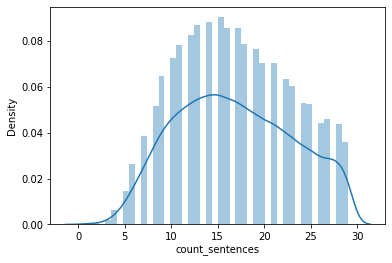

In [30]:
# story length distribution plot in the training dataset
train = train.sort_values(['story_id','sent_id'])
d2_sent_count = train.groupby('story_id').size().reset_index(name='count_sentences')
sns.distplot(d2_sent_count['count_sentences'])
plt.show()

In [31]:
# descriptive statistics of story length in the training dataset
d2_sent_count['count_sentences'].describe()

count    30000.000000
mean        16.828733
std          6.220425
min          1.000000
25%         12.000000
50%         16.000000
75%         22.000000
max         29.000000
Name: count_sentences, dtype: float64

In [32]:
# we note the maximum story length from the training dataset as we will
# be using this statistic for preprocessing
max_len_story = d2_sent_count['count_sentences'].max()
max_len_story

29

In [33]:
# total number of unique sentences in the training dataset
sent_ls = set(train['sentence'].tolist())
len(sent_ls)

484686

In [34]:
# unique labels in the training dataset
# 0: sentence is not a summary candidate
# 1: sentence is a summary candidate
tags = list(set(train['label_sent'].values))
n_tags = len(tags)
n_tags

2

In [35]:
# encoding the sentence labels and reversing them
tag2idx  = {t: i + 1 for i, t in enumerate(tags)}
tag2idx['PAD'] = 0
idx2tag = {i: s for s, i in tag2idx.items()}
print(tag2idx)

{0: 1, 1: 2, 'PAD': 0}


In [36]:
def add_word_lengths(df):
    df['word_len'] = df['sentence'].progress_apply(lambda x: len(x.split()))
    df['word_lis'] = df['sentence'].progress_apply(lambda x: x.split())
    return df

In [37]:
train = add_word_lengths(train)
valid = add_word_lengths(valid)
test = add_word_lengths(test)

train.head()

100%|██████████| 167713/167713 [00:00<00:00, 406848.19it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 167713/167713 [00:01<00:00, 90000.65it/s] 
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 168540/168540 [00:00<00:00, 204043.88it/s]


,story_id,sent_id,sentence,label_sent,word_len,word_lis
0,0,0,spains jorge lorenzo extended his lead in the ...,1,22,"[spains, jorge, lorenzo, extended, his, lead, ..."
1,0,1,the yamaha rider overhauled reigning world cha...,1,20,"[the, yamaha, rider, overhauled, reigning, wor..."
2,0,2,only a bad mistake with four laps to go might ...,0,37,"[only, a, bad, mistake, with, four, laps, to, ..."
3,0,3,it extended lorenzos lead over australias ston...,0,21,"[it, extended, lorenzos, lead, over, australia..."
4,0,4,it was wonderful fighting with casey were havi...,0,23,"[it, was, wonderful, fighting, with, casey, we..."


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


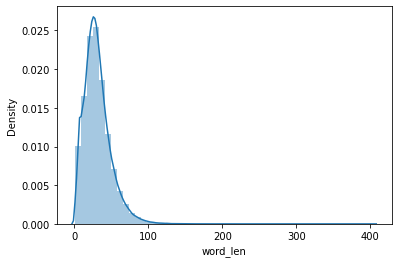

In [38]:
# sentence length distribution per story from the training dataset
sns.distplot(train['word_len'])
plt.show()

In [39]:
# descriptive statistics of sentence length distribution per story 
# from the training dataset
train['word_len'].describe()

count    504862.000000
mean         31.511579
std          18.168387
min           1.000000
25%          19.000000
50%          29.000000
75%          41.000000
max         404.000000
Name: word_len, dtype: float64

In [40]:
# total number of unique words in our training corpus
word_ls = set(list(chain(*train['word_lis'].tolist())))
n_words = len(word_ls)
print(n_words)

166180


In [41]:
# mapping the words to integers (tokenization) because machines don't
# understand raw text
word2idx = {c: i+2 for i,c in enumerate(word_ls)}
word2idx['UNK'] = 1
word2idx['PAD'] = 0

# reversing this dictionary as this would be needed for post-processing
idx2word = {i: s for s, i in word2idx.items()}

In [42]:
def append_sent_labels(df):
    df['sent_lab'] = df[['sentence','label_sent']].apply(tuple, axis=1)
    return df

In [43]:
train = append_sent_labels(train)
valid = append_sent_labels(valid)
test = append_sent_labels(test)

train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,story_id,sent_id,sentence,label_sent,word_len,word_lis,sent_lab
0,0,0,spains jorge lorenzo extended his lead in the ...,1,22,"[spains, jorge, lorenzo, extended, his, lead, ...",(spains jorge lorenzo extended his lead in the...
1,0,1,the yamaha rider overhauled reigning world cha...,1,20,"[the, yamaha, rider, overhauled, reigning, wor...",(the yamaha rider overhauled reigning world ch...
2,0,2,only a bad mistake with four laps to go might ...,0,37,"[only, a, bad, mistake, with, four, laps, to, ...",(only a bad mistake with four laps to go might...
3,0,3,it extended lorenzos lead over australias ston...,0,21,"[it, extended, lorenzos, lead, over, australia...",(it extended lorenzos lead over australias sto...
4,0,4,it was wonderful fighting with casey were havi...,0,23,"[it, was, wonderful, fighting, with, casey, we...",(it was wonderful fighting with casey were hav...
